In [1]:
using QuantumToolbox
# using PyPlot
using PythonCall
# using SymPy

BLAS.set_num_threads(1)

BosonOp = pyimport("sympy.physics.quantum.boson").BosonOp
Dagger = pyimport("sympy.physics.quantum").Dagger
Commutator = pyimport("sympy.physics.quantum").Commutator
normal_ordered_form = pyimport("sympy.physics.quantum.operatorordering").normal_ordered_form
linsolve = pyimport("sympy.solvers.solveset").linsolve
sym = pyimport("sympy")
np = pyimport("numpy")

geomspace(start, stop, n) = exp10.(range(log10(start), stop = log10(stop), length = n))

# plt = pyimport("matplotlib.pyplot")
# plt.rc("text", usetex = true)
# plt.rc("text.latex", preamble = raw"\usepackage{amsmath} \usepackage{physics}")
# plt.rc("axes", labelpad = 2)
# plt.rc("legend", frameon = false)
# plt.rc("font", size = 14)
# plt.rc("axes", labelsize = 14)    # fontsize of the x and y labels
# plt.rc("xtick", labelsize = 14)    # fontsize of the tick labels
# plt.rc("ytick", labelsize = 14)    # fontsize of the tick labels
# plt.rc("legend", fontsize = 13)

geomspace (generic function with 1 method)

## Quantum Rabi model

In [2]:
Nc = 80

ωc = 1
ωq = 1

a = kron(destroy(Nc), eye(2))

σm = kron(eye(Nc), sigmam())
σp = kron(eye(Nc), sigmap())
σz = kron(eye(Nc), sigmaz())
σx = kron(eye(Nc), sigmax())
σy = kron(eye(Nc), sigmay())

η_inversion_2_3 = 0.432993

# Coulomb gauge
H_C(η) = ωc * a'*a + ωq/2 * ( σz * cosm(2*η*(a+a')) + σy * sinm(2*η*(a+a')) )

# Dipole gauge
H_D(η) = ωc * a'*a + ωq/2 * σz + 1im * η * ωc * (a' - a) * σx + η^2 * ωc

H_D (generic function with 1 method)

In [4]:
plt = pyimport("matplotlib.pyplot")

Python: <module 'matplotlib.pyplot' from '/home/alberto/GitHub/PhD-Thesis-Notebooks/.CondaPkg/env/lib/python3.12/site-packages/matplotlib/pyplot.py'>

In [7]:
η_list = range(0, 2, 100)
n_vals = 6

eigs_d = zeros(length(η_list), n_vals)
eigs_c = zeros(length(η_list), n_vals)

Threads.@threads for i in eachindex(η_list)
    eigs_d[i, :] .= real.(eigsolve(H_D(η_list[i]), k=n_vals, sigma=-2).vals)
    eigs_c[i, :] .= real.(eigsolve(H_C(η_list[i]), k=n_vals, sigma=-2).vals)
end

fig, ax = plt.subplots(dpi=150)

ax.plot(η_list, eigs_c)
ax.plot(η_list, eigs_d, ls="--")
display(fig)

: 

In [3]:
ωc = 1
ωq = ωc + 1e-3

η_list = geomspace(1e-4, 3, 300)

res_c10_wrong = zeros(length(η_list))
res_c20_wrong = zeros(length(η_list))
res_c10_correct = zeros(length(η_list))
res_c20_correct = zeros(length(η_list))

Threads.@threads for i in eachindex(η_list)
    η = η_list[i]
    # vals_c, vecs_c = eigsolve(H_c(η), k=4, sigma=-1)
    vals_c, vecs_c = eigen(H_C(η))
    if η > η_inversion_2_3
        vecs_c[:, 3], vecs_c[:, 4] = vecs_c[:, 4], vecs_c[:, 3]
    end

    @views res_c10_wrong[i] = abs2(dot(vecs_c[:, 2], (σz).data, vecs_c[:, 2]) - dot(vecs_c[:, 1], (σz).data, vecs_c[:, 1])) / 4
    @views res_c20_wrong[i] = abs2(dot(vecs_c[:, 3], (σz).data, vecs_c[:, 3]) - dot(vecs_c[:, 1], (σz).data, vecs_c[:, 1])) / 4

    σz2 = σz * cosm(2*η*(a+a')) + σy * sinm(2*η*(a+a'))
    @views res_c10_correct[i] = abs2(dot(vecs_c[:, 2], (σz2).data, vecs_c[:, 2]) - dot(vecs_c[:, 1], (σz2).data, vecs_c[:, 1])) / 4
    @views res_c20_correct[i] = abs2(dot(vecs_c[:, 3], (σz2).data, vecs_c[:, 3]) - dot(vecs_c[:, 1], (σz2).data, vecs_c[:, 1])) / 4
end

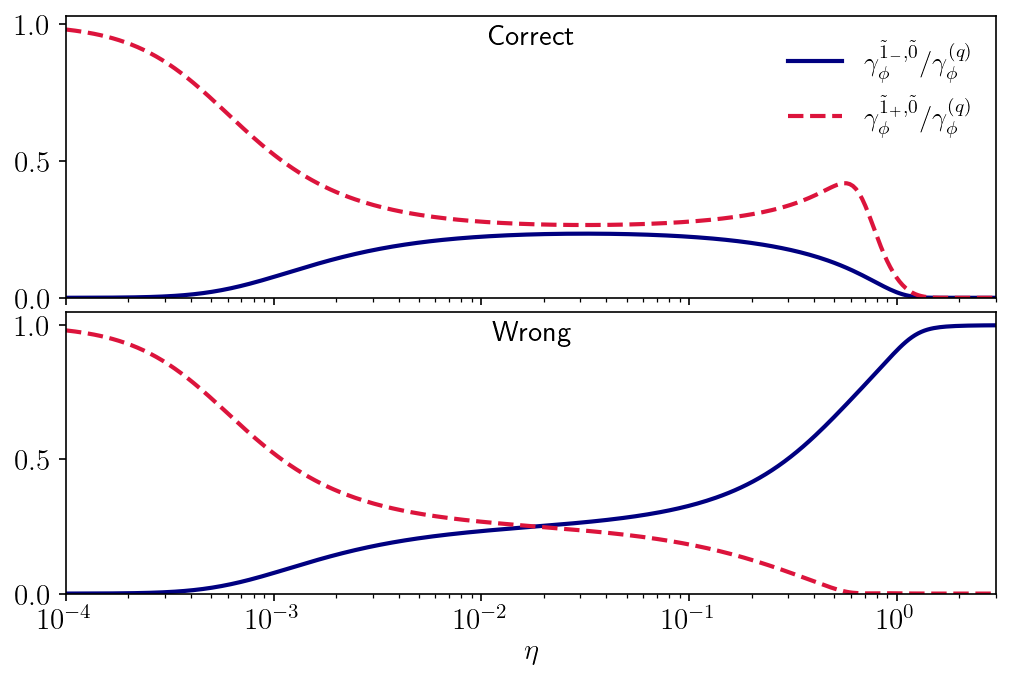

"/home/alberto/"

In [5]:
fig, axs = plt.subplots(2, 1, dpi=150, sharex=true, figsize = (8, 5), gridspec_kw=Dict("hspace"=>0.05, "wspace"=>0.05))

ax = axs[1]
ax.plot(η_list, res_c10_correct, color="navy", lw=2, label = L"$\gamma_\phi^{\tilde{1}_-,\tilde{0}} / \gamma_\phi^{(q)}$")
ax.plot(η_list, res_c20_correct, ls="--", color="crimson", lw=2, label = L"$\gamma_\phi^{\tilde{1}_+,\tilde{0}} / \gamma_\phi^{(q)}$")
ax.set_xscale("log")
ax.set_ylim(0, nothing)
ax.text(0.5, 0.9, "Correct", transform=ax.transAxes, ha="center")
ax.legend()

ax = axs[2]
ax.plot(η_list, res_c10_wrong, color="navy", lw=2)
ax.plot(η_list, res_c20_wrong, color="crimson", lw=2, ls="--")
ax.set_xscale("log")
ax.set_xlim(η_list[1], η_list[end])
ax.set_ylim(0, nothing)
ax.set_xlabel(L"$\eta$")
ax.text(0.5, 0.9, "Wrong", transform=ax.transAxes, ha="center")

root_dir = "/home/alberto/"
# root_dir = "/mnt/c/Users/alber/"
# plt.savefig(root_dir * "OneDrive/GitHub/Latex-Projects/phd-thesis/figures/pure_dephasing_rabi_atom.pdf", dpi=300, bbox_inches="tight")

## Hopfield model

In [5]:
function get_hopfield_matrix(H)
    M = sym.Matrix(np.zeros((4, 4)))

    for i in eachindex(ops)
        comm = normal_ordered_form(Commutator(ops[i], H).doit(independent=true).expand(), independent=true).expand()
        if Bool(pybuiltins.isinstance(comm, sym.Add))
            for arg in comm.args
                coeff = arg.args_cnc()[0]
                coeff = Bool(pybuiltins.isinstance(coeff, pybuiltins.list)) ? sym.prod(coeff) : coeff
                op = arg.args_cnc()[1]
                op = Bool(pybuiltins.isinstance(op, pybuiltins.list)) ? sym.prod(op) : op
                idx = findfirst(Bool.(op .== ops)) - 1
                M[idx, i-1] += coeff
            end
        elseif Bool(pybuiltins.isinstance(comm, sym.Mul))
            op = arg.args_cnc()[1]
            op = isa(op, Vector) ? sym.prod(op) : op
            println(op)
        end
    end

    M
end

function get_hopfield_coeff_C(ωc, ωb, λ)
    M = ComplexF64.(M_c(ωc, ωb, λ))
    Ω, U = eigen(M)

    # We are interested in those with positive eigenvalues
    @views norm_1 = sqrt( dot(U[:,3], η, U[:,3]) )
    @views norm_2 = sqrt( dot(U[:,4], η, U[:,4]) )
    @views U[:,3] ./= norm_1
    @views U[:,4] ./= norm_2

    return Ω[3:4], U[:,3:4]
end

function get_hopfield_coeff_D(ωc, ωb, λ)
    M = ComplexF64.(M_d(ωc, ωb, λ))
    Ω, U = eigen(M)

    # We are interested in those with positive eigenvalues
    @views norm_1 = sqrt( dot(U[:,3], η, U[:,3]) )
    @views norm_2 = sqrt( dot(U[:,4], η, U[:,4]) )
    @views U[:,3] ./= norm_1
    @views U[:,4] ./= norm_2

    return Ω[3:4], U[:,3:4]
end

get_hopfield_coeff_D (generic function with 1 method)

In [7]:
a = BosonOp("a") # resonator photon annihilation operator
a_d = Dagger(a)
b = BosonOp("b") # resonator photon annihilation operator
b_d = Dagger(b)

ops = [a, b, a_d, b_d]

ωc_s = sym.Symbol(raw"\omega_c", positive=true)
ωb_s = sym.Symbol(raw"\omega_b", positive=true)
λ_s = sym.Symbol(raw"\lambda", positive=true)

H_0 = ωc_s * a_d * a + ωb_s * b_d * b
H_int_c = -sym.I*ωb_s*λ_s*(b_d-b)*(a+a_d) + ωb_s*λ_s^2 * (a+a_d)^2
H_int_d = -sym.I*ωc_s*λ_s*(a-a_d)*(b+b_d) + ωc_s*λ_s^2 * (b+b_d)^2
H_test = H_0 + λ_s*(a+a_d)*(b+b_d)
H_c = H_0 + H_int_c
H_d = H_0 + H_int_d


# M_c = sym.utilities.lambdify((ωc_s, ωb_s, λ_s), get_hopfield_matrix(H_c), "numpy")
# M_d = lambdify(Sym(get_hopfield_matrix(H_d)), (ωc_s, ωb_s, λ_s))

η = Diagonal([1,1,-1,-1])

4×4 Diagonal{Int64, Vector{Int64}}:
 1  ⋅   ⋅   ⋅
 ⋅  1   ⋅   ⋅
 ⋅  ⋅  -1   ⋅
 ⋅  ⋅   ⋅  -1

In [1]:
using PythonCall

In [2]:
sym = pyimport("sympy")

a = sym.Symbol("a")
# lambdify(a, a);

Python: a

In [7]:
@pyexec """
def lambdify(*args):
    import sympy
    return sympy.lambdify(*args)
""" => lambdify

Python: <function lambdify at 0x75572bbf68e0>

In [9]:
lambdify(a, a)(1.0)

Python: 1.0

In [11]:
prova = lambdify(a, a)

Python: <function _lambdifygenerated at 0x75571c324f40>

In [16]:
pyconvert(Int, prova(1))

1

In [5]:
a = Symbol("a")

lambdify(a, a)

LoadError: MethodError: no method matching lambdify(::Symbol, ::Symbol)

[0mClosest candidates are:
[0m  lambdify([91m::Array{S, N}[39m, ::Any; T, kwargs...) where {S<:Sym, N}
[0m[90m   @[39m [35mSymPyCore[39m [90m~/.julia/packages/SymPyCore/yYiXE/src/[39m[90m[4mlambdify.jl:409[24m[39m
[0m  lambdify([91m::Sym[39m, ::Any; fns, values, use_julia_code, invoke_latest)
[0m[90m   @[39m [35mSymPyCore[39m [90m~/.julia/packages/SymPyCore/yYiXE/src/[39m[90m[4mlambdify.jl:360[24m[39m


In [11]:
prova = lambdify(x,(x,))

#150 (generic function with 1 method)

In [13]:
prova(2.4)

2.4

LoadError: Python: AttributeError: 'NoneType' object has no attribute 'f_locals'

In [25]:
pyeval(sym.simplify, ωc_s, ωc_s)

LoadError: Python: TypeError: locals must be a mapping

In [6]:
get_hopfield_matrix(H_c)

LoadError: Python: AttributeError: Julia: type Array has no field ravel

In [10]:
lambdify([ωc_s, ωb_s, λ_s], get_hopfield_matrix(H_c))

LoadError: UndefVarError: `lambdify` not defined

In [45]:
lambdify([ωc_s, ωb_s, λ_s], get_hopfield_matrix(H_c))

LoadError: MethodError: no method matching lambdify(::Vector{PyObject}, ::PyObject)

[0mClosest candidates are:
[0m  lambdify([91m::Array{S, N}[39m, ::Any; T, kwargs...) where {S<:Sym, N}
[0m[90m   @[39m [36mSymPyCore[39m [90m~/.julia/packages/SymPyCore/yYiXE/src/[39m[90m[4mlambdify.jl:409[24m[39m
[0m  lambdify([91m::Sym[39m, ::Any; fns, values, use_julia_code, invoke_latest)
[0m[90m   @[39m [36mSymPyCore[39m [90m~/.julia/packages/SymPyCore/yYiXE/src/[39m[90m[4mlambdify.jl:360[24m[39m


In [29]:
get_hopfield_matrix(H_c)

PyObject Matrix([
[2*\lambda**2*\omega_b + \omega_c, -I*\lambda*\omega_b,            -2*\lambda**2*\omega_b, -I*\lambda*\omega_b],
[              I*\lambda*\omega_b,            \omega_b,               -I*\lambda*\omega_b,                   0],
[           2*\lambda**2*\omega_b, -I*\lambda*\omega_b, -2*\lambda**2*\omega_b - \omega_c, -I*\lambda*\omega_b],
[             -I*\lambda*\omega_b,                   0,                I*\lambda*\omega_b,           -\omega_b]])

In [40]:
get_hopfield_coeff_C(ωc, ωb, 0.1)

LoadError: UndefVarError: `ImmutableDenseMatrix` not defined

In [8]:
ωc = 1
ωb = 0.8
λ_list = range(0, 5, 100)

E_c_l = similar(λ_list)
E_d_l = similar(λ_list)
E_c_u = similar(λ_list)
E_d_u = similar(λ_list)

for i in eachindex(λ_list)
    Ω_c, U_c = get_hopfield_coeff_C(ωc, ωb, λ_list[i])
    Ω_d, U_d = get_hopfield_coeff_D(ωc, ωb, λ_list[i])
    E_c_l[i] = real(Ω_c[1])
    E_d_l[i] = real(Ω_d[1])
    E_c_u[i] = real(Ω_c[2])
    E_d_u[i] = real(Ω_d[2])
end

fig, ax = plt.subplots(dpi=150)

ax.plot(λ_list, E_c_l, color="navy", lw=2, label = L"$\tilde{E}_{1_-}$")
ax.plot(λ_list, E_c_u, color="navy", lw=2, label = L"$\tilde{E}_{1_+}$")
ax.plot(λ_list, E_d_l, color="crimson", lw=2, ls="--", label = L"$\tilde{E}_{1_-}$")
ax.plot(λ_list, E_d_u, color="crimson", lw=2, ls="--", label = L"$\tilde{E}_{1_+}$")
ax.set_xlim(λ_list[1], λ_list[end])
ax.set_ylim(0, nothing)
ax.set_xlabel(L"$\lambda$")
ax.legend()

LoadError: UndefVarError: `M_c` not defined

In [7]:
fig, axs = plt.subplots(2, 1, dpi=150, sharex=true, figsize = (8, 5), gridspec_kw=Dict("hspace"=>0.05, "wspace"=>0.05))

ax = axs[1]
ax.plot(η_list, dep_l, color="navy", lw=2, label = L"$\gamma_\phi^{1} / \gamma_\phi^{(x)}$")
ax.plot(η_list, dep_u, ls="--", color="crimson", lw=2, label = L"$\gamma_\phi^{2} / \gamma_\phi^{(x)}$")
ax.set_xscale("log")
ax.set_ylim(0, nothing)
ax.text(0.5, 0.9, "Correct", transform=ax.transAxes, ha="center")
ax.legend()

ax = axs[2]
ax.plot(η_list, dep_l_wrong, color="navy", lw=2)
ax.plot(η_list, dep_u_wrong, color="crimson", lw=2, ls="--")
ax.set_xscale("log")
ax.set_xlim(η_list[1], η_list[end])
ax.set_ylim(0, nothing)
ax.set_xlabel(L"$\eta$")
ax.text(0.5, 0.9, "Wrong", transform=ax.transAxes, ha="center")

root_dir = "/home/alberto/"
# root_dir = "/mnt/c/Users/alber/"
plt.savefig(root_dir * "OneDrive/GitHub/Latex-Projects/phd-thesis/figures/pure_dephasing_hopfield_atom.pdf", dpi=300, bbox_inches="tight")

LoadError: UndefVarError: `dep_l` not defined